In [1]:
import pandas as pd

import numpy as np

import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

import seaborn as sn

import random
import os

In [2]:
sequence_path = "chr_seq/"
annotation_path = "combined_annotations.csv"

In [3]:
annotations = pd.read_csv(annotation_path, sep='\t')

In [4]:
annotations['label'] = np.where(
    (annotations['label'] == 'CTCF') | (annotations['label'] == 'K4m3'), 
    'junk', 
    annotations['label']
)

In [5]:
annotations['label'] = np.where(
    annotations['label'] == 'junk', 
    'other', 
    annotations['label']
)

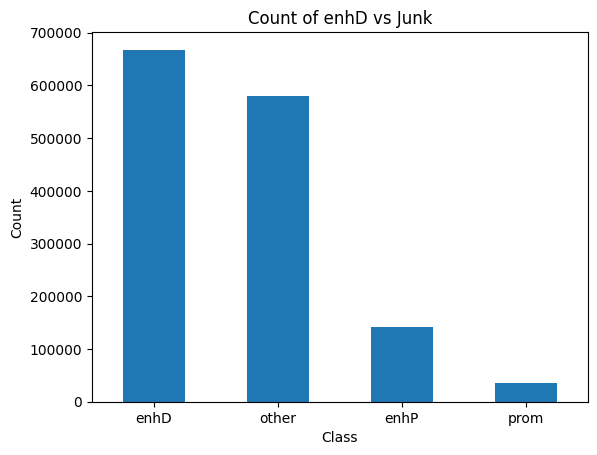

In [6]:


class_counts = annotations['label'].value_counts()

# Plot the counts
class_counts.plot(kind='bar')
plt.title('Count of enhD vs Junk')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels to show them horizontally
plt.show()



In [7]:
class_counts

label
enhD     667599
other    580041
enhP     141830
prom      34803
Name: count, dtype: int64

In [8]:
num_enhP = len(annotations[annotations['label'] == 'prom'])
num_enhP

34803

In [9]:
ann_temp = annotations[annotations['label'] == 'prom'].copy()
# ann_temp = annotations[annotations['label'].isin(['prom','enhP'])].copy()

# Randomly sample 'junk' annotations to match the number of 'prom' annotations
for label in ['enhD','enhP', 'other']:

# for label in ['enhD', 'other']:
    
    annotations_sampled = annotations[annotations['label'] == label].sample(n=num_enhP, random_state=42)

    ann_temp = pd.concat([ann_temp, annotations_sampled])

# Now you can proceed to create your dataset with 'balanced_annotations'
# instead of the full 'annotations' DataFrame

In [10]:
annotations = ann_temp

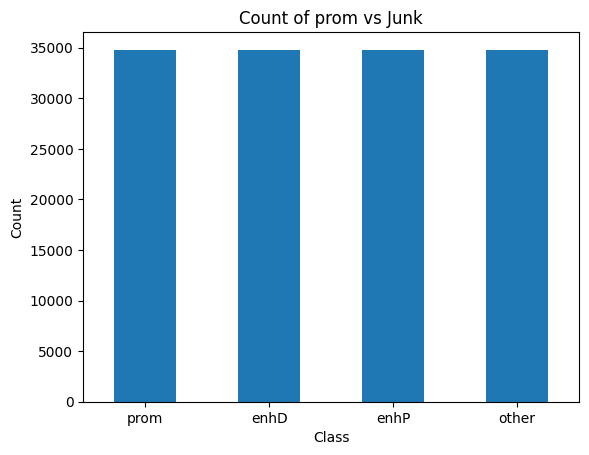

In [11]:
class_counts = annotations['label'].value_counts()

# Plot the counts
class_counts.plot(kind='bar')
plt.title('Count of prom vs Junk')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels to show them horizontally
plt.show()



In [12]:
annotations.head()

,chrom,frameStart,frameEnd,label
4,chr1,778561,778961,prom
5,chr1,779047,779447,prom
14,chr1,817029,817429,prom
23,chr1,827291,827691,prom
48,chr1,870102,870502,prom


In [13]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd


class DNADataset(Dataset):
    def __init__(self, sequence, annotations, encoding_type='integer'):
        self.sequence = sequence
        self.annotations = annotations
        self.encoding_type = encoding_type
        self.sections = self._extract_sections()
    
    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):     
        start, end, label = self.sections[index]
        sequence_section = self.sequence[start:end]
        sequence_section = [self._map_dna_letter(letter) for letter in sequence_section]
        sequence_section = torch.tensor(sequence_section).T
        
        return sequence_section, label
    
    def _extract_sections(self):
        sections = []
        # Iterate over each annotation
        for _, row in self.annotations.iterrows():
            start = row['frameStart']
            end = row['frameEnd']
            label = self._map_annotation_type(row['label'])
            sections.append((start, end, label))
        return sections

    def _map_dna_letter(self, letter):
        if self.encoding_type == 'integer':
            if letter == 'A':
                return 1
            elif letter == 'C':
                return 2
            elif letter == 'G':
                return 3
            elif letter == 'T':
                return 4
            elif letter == 'N':
                return 5
            else:
                raise ValueError(f"Invalid DNA letter: {letter}")
        elif self.encoding_type == 'one_hot':
            if letter == 'A':
                return [1, 0, 0, 0]
            elif letter == 'C':
                return [0, 1, 0, 0]
            elif letter == 'G':
                return [0, 0, 1, 0]
            elif letter == 'T':
                return [0, 0, 0, 1]
            elif letter == 'N':
                return [0, 0, 0, 0]
            else:
                raise ValueError(f"Invalid DNA letter: {letter}")
        else:
            raise ValueError(f"Invalid encoding type: {self.encoding_type}")
    
    @staticmethod
    def _map_annotation_type(annotation_type):
        if annotation_type == 'prom':
            return 1
        elif annotation_type == 'enhP':
            return 2
        elif annotation_type == 'enhD':
            return 3
        elif annotation_type == 'other':
            return 0

In [14]:
# Create a list of chromosome names including chrX and chrY
chr_sequences = [f'chr{i}' for i in range(1, 23)] + ['chrX', 'chrY']

dataset = []

for seq in chr_sequences:
    # Read DNA sequence file
    print(f'Processing {seq}...')
    sequence_file_path = f'{sequence_path}/{seq}.fa'
    annotations_for_seq = annotations[annotations['chrom'] == seq]
    print(f'Number of annotations for {seq}: {annotations_for_seq.shape[0]}')
    
    with open(sequence_file_path, 'r') as file:
        # Skip the first line which is the header
        next(file)
        # Read the sequence, remove newlines and convert to uppercase
        dna_sequence = file.read().replace("\n", "").upper()
        
        # Initialize the dataset for this chromosome with its annotations
        ds = DNADataset(dna_sequence, annotations_for_seq, encoding_type='one_hot')
        # Extend the main dataset with the data from this chromosome
        dataset.extend(ds)

# Split into training and testing sets (adjust ratios as per your needs)
train_size = int(0.9 * len(dataset))
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])



Processing chr1...
Number of annotations for chr1: 12646
Processing chr2...
Number of annotations for chr2: 10830
Processing chr3...
Number of annotations for chr3: 8868
Processing chr4...
Number of annotations for chr4: 6694
Processing chr5...
Number of annotations for chr5: 7309
Processing chr6...
Number of annotations for chr6: 7877
Processing chr7...
Number of annotations for chr7: 7197
Processing chr8...
Number of annotations for chr8: 6218
Processing chr9...
Number of annotations for chr9: 5585
Processing chr10...
Number of annotations for chr10: 6202
Processing chr11...
Number of annotations for chr11: 7320
Processing chr12...
Number of annotations for chr12: 7361
Processing chr13...
Number of annotations for chr13: 3402
Processing chr14...
Number of annotations for chr14: 4859
Processing chr15...
Number of annotations for chr15: 4566
Processing chr16...
Number of annotations for chr16: 4949
Processing chr17...
Number of annotations for chr17: 6625
Processing chr18...
Number of 

In [15]:
train_dataset.__len__()

125290

In [16]:
print(train_dataset.__getitem__(1))

(tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 1, 1, 1]]), 0)


In [17]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(4, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 50, 128)  # Assuming max pooling is applied 3 times
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 4)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = self.flatten(x)
        x = nn.functional.relu(self.fc1(self.dropout(x)))
        x = nn.functional.relu(self.fc2(self.dropout(x)))
        x = self.fc3(x)
        return x


In [18]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Define the training parameters
batch_size = 64
num_epochs = 30
learning_rate = 0.001

# Create DataLoader instances for training and testing sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)




In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [20]:

# Create an instance of the CNN model
model = CNN()
model.to(device)
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to train mode
    total_loss = 0.0
    correct_predictions = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Zero the gradients

        # Convert data types
        inputs = inputs.float()
        labels = labels.long()
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track training loss and accuracy
        total_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == labels).sum().item()

    # Calculate average loss and accuracy for the epoch
    avg_loss = total_loss / len(train_dataset)
    accuracy = correct_predictions / len(train_dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")


Epoch [1/30], Loss: 1.1551, Accuracy: 0.4488
Epoch [2/30], Loss: 1.1180, Accuracy: 0.4820
Epoch [3/30], Loss: 1.1055, Accuracy: 0.4909
Epoch [4/30], Loss: 1.0960, Accuracy: 0.4960
Epoch [5/30], Loss: 1.0887, Accuracy: 0.5023
Epoch [6/30], Loss: 1.0818, Accuracy: 0.5054
Epoch [7/30], Loss: 1.0755, Accuracy: 0.5101
Epoch [8/30], Loss: 1.0694, Accuracy: 0.5153
Epoch [9/30], Loss: 1.0663, Accuracy: 0.5182
Epoch [10/30], Loss: 1.0598, Accuracy: 0.5216
Epoch [11/30], Loss: 1.0564, Accuracy: 0.5250
Epoch [12/30], Loss: 1.0509, Accuracy: 0.5274
Epoch [13/30], Loss: 1.0484, Accuracy: 0.5294
Epoch [14/30], Loss: 1.0430, Accuracy: 0.5324
Epoch [15/30], Loss: 1.0396, Accuracy: 0.5342
Epoch [16/30], Loss: 1.0359, Accuracy: 0.5354
Epoch [17/30], Loss: 1.0314, Accuracy: 0.5375
Epoch [18/30], Loss: 1.0303, Accuracy: 0.5385
Epoch [19/30], Loss: 1.0266, Accuracy: 0.5405
Epoch [20/30], Loss: 1.0230, Accuracy: 0.5443
Epoch [21/30], Loss: 1.0199, Accuracy: 0.5457
Epoch [22/30], Loss: 1.0173, Accuracy: 0.54

In [21]:
# Evaluate the model on the test set
model.eval()  # Set the model to evaluation mode
total_loss = 0.0
correct_predictions = 0
predicted_labels = []
true_labels = []

for inputs, labels in test_loader:
    # Convert data types
    inputs = inputs.float()
    labels = labels.long()
    inputs, labels = inputs.to(device), labels.to(device)

    
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    total_loss += loss.item() * inputs.size(0)
    _, predicted = torch.max(outputs.data, 1)
    correct_predictions += (predicted == labels).sum().item()
    
    # true_labels.append(labels.numpy().flatten())
    # predicted_labels.append(predicted.numpy().flatten())
    true_labels.append(labels.cpu().numpy().flatten())  # Move labels to CPU and convert to NumPy
    predicted_labels.append(predicted.cpu().numpy().flatten())  # Move predicted labels to CPU and convert to NumPy

avg_loss = total_loss / len(test_dataset)
accuracy = correct_predictions / len(test_dataset)

print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}")

Test Loss: 1.0781, Test Accuracy: 0.5115


In [22]:
true_labels = np.concatenate(true_labels)
predicted_labels = np.concatenate(predicted_labels)

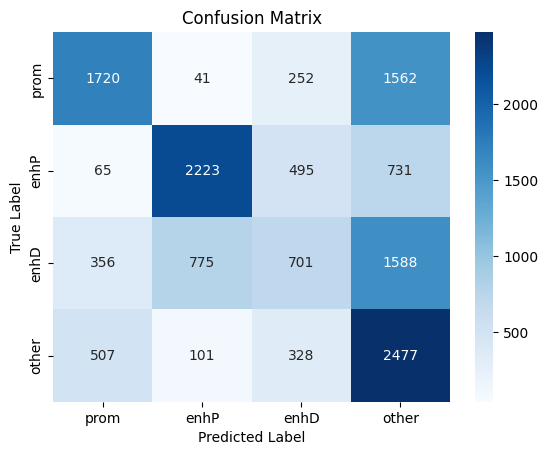

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.48      0.55      3575
           1       0.71      0.63      0.67      3514
           2       0.39      0.20      0.27      3420
           3       0.39      0.73      0.51      3413

    accuracy                           0.51     13922
   macro avg       0.54      0.51      0.50     13922
weighted avg       0.54      0.51      0.50     13922



In [23]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Define class names
class_names = ['prom', 'enhP', 'enhD', 'other']  # Updated list of class names

# Create a confusion matrix plot
fig, ax = plt.subplots()
sn.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names, ax=ax)



# Add labels, title, and ticks
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix')



# Show the plot
plt.show()

report = classification_report(true_labels, predicted_labels)

# Print the confusion matrix and classification report
# print('Confusion Matrix:')
# print(confusion_mat)
print('Classification Report:')
print(report)

